In [1]:
import re
import pandas as pd
from collections import defaultdict

def parse_usf(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    header_info = {}
    array_info = {}
    sweeps = []
    current_sweep = None
    in_data_block = False
    data_rows = []

    for line in lines:
        stripped_line = line.strip()
        if not stripped_line:
            continue

        # Header info
        if stripped_line.startswith("//"):
            key_value = stripped_line[2:].split(":", 1)
            if len(key_value) == 2:
                key, value = key_value[0].strip(), key_value[1].strip()
                header_info[key] = value
            continue
            
        # Sweep metadata
        if stripped_line.startswith("/SWEEP_NUMBER"):
            if current_sweep:  # Save previous sweep
                current_sweep["data"] = pd.DataFrame(data_rows, columns=["TIME", "VOLTAGE", "QUALITY"])
                sweeps.append(current_sweep)
                data_rows = []
            current_sweep = {}
            key_value = stripped_line[1:].split(":", 1)
            current_sweep[key_value[0].strip()] = key_value[1].strip()
            continue

        if stripped_line.startswith("/") and not stripped_line.startswith("/END"):
            if current_sweep is None:
                current_sweep = {}
            key_value = stripped_line[1:].split(":", 1)
            if len(key_value) == 2:
                current_sweep[key_value[0].strip()] = key_value[1].strip()
            continue

        # Data block start
        if stripped_line.startswith("TIME,"):
            in_data_block = True
            continue

        if stripped_line == "/END":
            in_data_block = False
            continue

        # Data inside block
        if in_data_block:
            # Split by comma or whitespace
            parts = re.split(r"[\s,]+", stripped_line.strip())
            parts = [p for p in parts if p]  # Remove empty strings
            if len(parts) >= 3:
                try:
                    time_val = float(parts[0])
                    voltage_val = float(parts[1])
                    quality_val = int(parts[2])
                    data_rows.append([time_val, voltage_val, quality_val])
                except ValueError:
                    pass

    # Append last sweep
    if current_sweep:
        current_sweep["data"] = pd.DataFrame(data_rows, columns=["TIME", "VOLTAGE", "QUALITY"])
        sweeps.append(current_sweep)

    return header_info, sweeps[0], sweeps[1:]

In [2]:
"/ARRAY: FIXED LOOP TEM".strip()

'/ARRAY: FIXED LOOP TEM'

In [3]:
# import ace_tools as tools; tools.display_dataframe_to_user(name="First Sweep Data", dataframe=sweeps[0]["data"])

file_path = "./20240724_175232_318_Station1.usf"  # Replace with your file name
header_info, array_info, sweeps = parse_usf(file_path)

print("Header Info:")
for k, v in header_info.items():
    print(f"{k}: {v}")

print("\nNumber of sweeps parsed:", len(sweeps))
for i, sweep in enumerate(sweeps[:2]):  # show first two sweeps
    print(f"\nSweep {i+1} Metadata:")
    for key, val in sweep.items():
        if key != "data":
            print(f"{key}: {val}")
    print("Data sample:")
    print(sweep["data"].head())


Header Info:
USF: Universal Sounding Format
SOUNDINGS: 1
EPSG: 32614
SOUNDING_GROUP_NAME: Project7
USF_WRITER_PROGRAM: WalkTEMImporter.exe
USF_WRITER_PROGRAM_VERSION: 3.2.1.0
DUMMY: dummy

Number of sweeps parsed: 218

Sweep 1 Metadata:
SWEEP_NUMBER: 1
CURRENT: 12.45
FREQUENCY: 30.0
SWEEP_IS_NOISE: 0
DATE: 20240724
DAYTIME: 17.88
COIL_SIZE: 1400
FIELD_SHIFT_FACTOR: 1
TIME_DELAY: 0
RAMP_TIME: 0
RAMP_TIME_ON: 0
RX_FRONTGATE: 1.25E-5
TX_TURNONTIME: -0.008333
POINTS: 31
LOW_PASS: 150000, 1, 450000, 1
CHANNEL: 1
STACK_SIZE: 500
COIL_LOCATION: 0.0000, 0.0000
Data sample:
       TIME   VOLTAGE  QUALITY
0  0.000002  0.000088        0
1  0.000006  0.000198        0
2  0.000010  0.000059        0
3  0.000014  0.000045        0
4  0.000018  0.000012        1

Sweep 2 Metadata:
SWEEP_NUMBER: 2
CURRENT: 12.40
FREQUENCY: 30.0
SWEEP_IS_NOISE: 0
DATE: 20240724
DAYTIME: 17.89
COIL_SIZE: 1400
FIELD_SHIFT_FACTOR: 1
TIME_DELAY: 0
RAMP_TIME: 0
RAMP_TIME_ON: 0
RX_FRONTGATE: 1.25E-5
TX_TURNONTIME: -0.008333


In [4]:
array_info

{'ARRAY': 'FIXED LOOP TEM',
 'LOOP_SIZE': '20,20',
 'SOUNDING_NAME': 'Station1',
 'SOUNDING_NUMBER': '1',
 'SWEEPS': '218',
 'PROFILE': 'Project7',
 'INSTRUMENT': '26290003_1.3.8.0',
 'LOCATION': '625634.4841, 5535695.1452, 260.7',
 'Z_DIRECTION': 'DOWN',
 'LENGTH_UNITS': 'M',
 'VOLTAGE_UNITS': 'V/AM2',
 'data': Empty DataFrame
 Columns: [TIME, VOLTAGE, QUALITY]
 Index: []}

In [5]:
len(sweeps)

218

In [6]:
import matplotlib.pyplot as plt

In [7]:
len(sweeps)

218

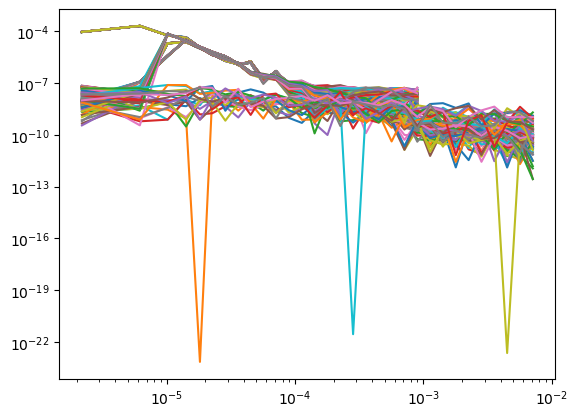

In [8]:
for ii in range(len(sweeps)):
    times = sweeps[ii]['data']['TIME'].values
    voltages = sweeps[ii]['data']['VOLTAGE'].values
    plt.loglog(times, abs(voltages))


In [9]:
import numpy as np


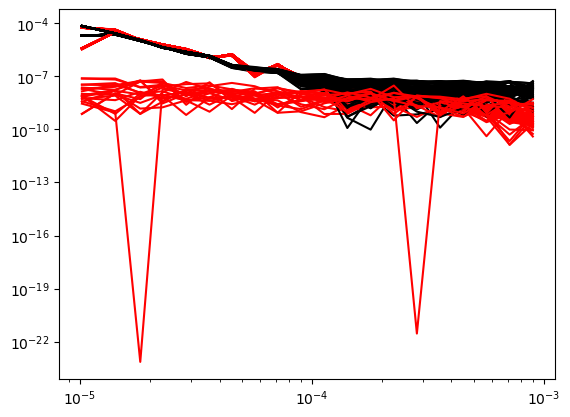

In [10]:
tx_turnon_time = []
moment = []
for ii in range(len(sweeps)):
    times = sweeps[ii]['data']['TIME'].values
    voltages = sweeps[ii]['data']['VOLTAGE'].values    
    tx_turnon_time.append(sweep['TX_TURNONTIME'])
    active_inds = np.logical_and(times>1e-5, times<1e-3)
    if sweeps[ii]['TX_TURNONTIME'] == '-0.001041':    
        moment.append('lm')
        plt.loglog(times[active_inds], abs(voltages)[active_inds], 'k')
    else:
        plt.loglog(times[active_inds], abs(voltages)[active_inds], 'r')
        moment.append('hm')

In [11]:
lm_inds =  np.argwhere(np.array(moment)=='lm').ravel().tolist()[:-2] # remove the last two noisy data
hm_inds =  np.argwhere(np.array(moment)=='hm').ravel().tolist()[:-2] # remove the last two noisy data

In [12]:
sweeps_lm = np.array(sweeps)[lm_inds].tolist()
sweeps_hm = np.array(sweeps)[hm_inds].tolist()

In [13]:
sweeps_hm[0]

{'SWEEP_NUMBER': '1',
 'CURRENT': '12.45',
 'FREQUENCY': '30.0',
 'SWEEP_IS_NOISE': '0',
 'DATE': '20240724',
 'DAYTIME': '17.88',
 'COIL_SIZE': '1400',
 'FIELD_SHIFT_FACTOR': '1',
 'TIME_DELAY': '0',
 'RAMP_TIME': '0',
 'RAMP_TIME_ON': '0',
 'RX_FRONTGATE': '1.25E-5',
 'TX_TURNONTIME': '-0.008333',
 'POINTS': '31',
 'LOW_PASS': '150000, 1, 450000, 1',
 'CHANNEL': '1',
 'STACK_SIZE': '500',
 'COIL_LOCATION': '0.0000, 0.0000',
 'data':         TIME       VOLTAGE  QUALITY
 0   0.000002  8.815360e-05        0
 1   0.000006  1.980850e-04        0
 2   0.000010  5.930370e-05        0
 3   0.000014  4.471060e-05        0
 4   0.000018  1.150740e-05        1
 5   0.000023  6.101380e-06        1
 6   0.000029  3.319880e-06        1
 7   0.000036  1.126770e-06        1
 8   0.000045 -1.727310e-06        1
 9   0.000057  1.964560e-07        1
 10  0.000071  3.893060e-07        1
 11  0.000090  1.059620e-07        1
 12  0.000113  6.731110e-08        1
 13  0.000142  1.326850e-08        1
 14  0.

In [14]:
sweeps_lm[0]

{'SWEEP_NUMBER': '50',
 'CURRENT': '1.12',
 'FREQUENCY': '240.0',
 'SWEEP_IS_NOISE': '0',
 'DATE': '20240724',
 'DAYTIME': '17.88',
 'COIL_SIZE': '1400',
 'FIELD_SHIFT_FACTOR': '1',
 'TIME_DELAY': '0',
 'RAMP_TIME': '0',
 'RAMP_TIME_ON': '0',
 'RX_FRONTGATE': '9.5E-6',
 'TX_TURNONTIME': '-0.001041',
 'POINTS': '22',
 'LOW_PASS': '150000, 1, 450000, 1',
 'CHANNEL': '2',
 'STACK_SIZE': '960',
 'COIL_LOCATION': '0.0000, 0.0000',
 'data':         TIME       VOLTAGE  QUALITY
 0   0.000002 -5.382890e-08        0
 1   0.000006 -2.337950e-08        0
 2   0.000010  2.031330e-05        0
 3   0.000014  2.359900e-05        1
 4   0.000018  1.009750e-05        1
 5   0.000023  4.505820e-06        1
 6   0.000029  1.938700e-06        1
 7   0.000036  1.213930e-06        1
 8   0.000045  3.694510e-07        1
 9   0.000057  2.101050e-07        1
 10  0.000071  1.698000e-07        1
 11  0.000090  6.261140e-08        1
 12  0.000113  3.525960e-08        1
 13  0.000142 -1.496970e-08        1
 14  0.

In [15]:
from ipywidgets import widgets, interact
def foo(n_sweep_trial):
    for ii in range(n_sweep_trial):
        times = sweeps_lm[ii]['data']['TIME'].values
        voltages = sweeps_lm[ii]['data']['VOLTAGE'].values   
        active_inds = np.logical_and(times>1e-6, times<1e-1)
        plt.loglog(times[active_inds], abs(voltages)[active_inds], 'k,-')
    for ii in range(n_sweep_trial):
        times = sweeps_hm[ii]['data']['TIME'].values
        voltages = sweeps_hm[ii]['data']['VOLTAGE'].values   
        active_inds = np.logical_and(times>1e-6, times<1e-1)
        plt.loglog(times[active_inds], abs(voltages)[active_inds], 'r,-')   
interact(foo, n_sweep_trial=widgets.IntSlider(min=0, max=(len(sweeps_lm)), step=1, value=10))

interactive(children=(IntSlider(value=10, description='n_sweep_trial', max=98), Output()), _dom_classes=('widg…

<function __main__.foo(n_sweep_trial)>

In [16]:
n_sweep_trial = 49

In [17]:
# import libaarhusxyz
# system = libaarhusxyz.parse_gex("/Users/sgkang09/Downloads/Station1/20250730_232137_572_RunConf.ini")

In [18]:
from configparser import ConfigParser

def parse_ini_file(file_path):
    parser = ConfigParser()
    parser.optionxform = str  # preserve case sensitivity
    parser.read(file_path)

    ini_data = {}
    for section in parser.sections():
        ini_data[section] = dict(parser.items(section))

    return ini_data

# Parse the uploaded .ini file
ini_file_path = "20240724_175232_318_RunConf.ini"
ini_data = parse_ini_file(ini_file_path)

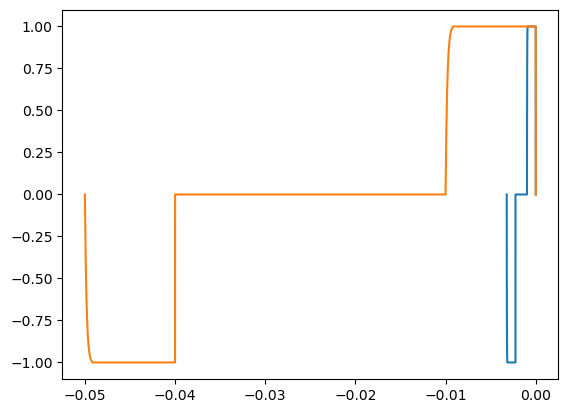

In [19]:
values_lm = np.array(ini_data['Config']['TXRampLM'].split(',')).astype(float)
time_input_currents_lm = values_lm[::2]
input_currents_lm = values_lm[1::2]
values_hm = np.array(ini_data['Config']['TXRampHM'].split(',')).astype(float)
time_input_currents_hm = values_hm[::2]
input_currents_hm = values_hm[1::2]
plt.plot(time_input_currents_lm, input_currents_lm, '-')
plt.plot(time_input_currents_hm, input_currents_hm, '-')

In [20]:
# SimPEG functionality
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.utils import plot_1d_layer_model, download, mkvc
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [21]:
bw_cutoff_frequency_lm = float(ini_data['Instrument']['InstrumentFilter'])
bw_power_lm = float(ini_data['Instrument']['InstrumentFilterOrder'])
bw_cutoff_frequency_hm = float(ini_data['Instrument']['InstrumentFilter'])
bw_power_hm = float(ini_data['Instrument']['InstrumentFilterOrder'])
lp_cutoff_frequency_lm = float(ini_data['Config']['RXCoilFilterCh1'])
lp_power_lm = float(ini_data['Config']['RXCoilFilterOrderCh1'])
lp_cutoff_frequency_hm = float(ini_data['Config']['RXCoilFilterCh2'])
lp_power_hm = float(ini_data['Config']['RXCoilFilterOrderCh2'])

In [22]:
print (bw_cutoff_frequency_lm, bw_power_lm)

print (lp_cutoff_frequency_lm, lp_power_lm)

print (lp_cutoff_frequency_hm, lp_power_hm)

450000.0 1.0
150000.0 1.0
450000.0 1.0


In [23]:
print (bw_cutoff_frequency_lm, bw_power_lm)

print (bw_cutoff_frequency_hm, bw_power_hm)

450000.0 1.0
450000.0 1.0


In [24]:
delay_lm = -float(sweeps_lm[0]['TIME_DELAY'])
delay_hm = -float(sweeps_hm[0]['TIME_DELAY'])

In [25]:
# # TODO: figure out on how to select sweeps and average?
# ii = 0 # choose the first sweep
# times_lm = sweeps_lm[ii]['data']['TIME'].values + delay_lm
# voltages_lm = sweeps_lm[ii]['data']['VOLTAGE'].values   
# inds_lm = sweeps_lm[ii]['data']['QUALITY'].values.astype(bool)
# times_hm = sweeps_hm[ii]['data']['TIME'].values + delay_hm
# voltages_hm = sweeps_hm[ii]['data']['VOLTAGE'].values   
# inds_hm = sweeps_hm[ii]['data']['QUALITY'].values.astype(bool)
# times_ch1 = times_lm[inds_lm]
# voltages_ch1 = voltages_lm[inds_lm]
# times_ch2 = times_hm[inds_hm]
# voltages_ch2 = voltages_hm[inds_hm]

In [26]:
n_channels_lm = sweeps_lm[0]['data'].shape[0]
n_channels_hm = sweeps_hm[0]['data'].shape[0]

In [27]:
data_lm_mat = np.zeros((n_sweep_trial, n_channels_lm))
quality_lm_mat = np.zeros((n_sweep_trial, n_channels_lm))

data_hm_mat = np.zeros((n_sweep_trial, n_channels_hm))
quality_hm_mat = np.zeros((n_sweep_trial, n_channels_hm))

In [28]:
# TODO: figure out on how to select sweeps and average?
ii = 0 # choose the first sweep
times_lm = sweeps_lm[ii]['data']['TIME'].values + delay_lm
times_hm = sweeps_hm[ii]['data']['TIME'].values + delay_hm
# times_ch1 = times_lm[inds_lm]
# times_ch2 = times_hm[inds_hm]

In [29]:
for ii in range(n_sweep_trial):
    data_lm_mat[ii,:] = sweeps_lm[ii]['data']['VOLTAGE']
    quality_lm_mat[ii,:] = sweeps_lm[ii]['data']['QUALITY']
    data_hm_mat[ii,:] = sweeps_hm[ii]['data']['VOLTAGE']
    quality_hm_mat[ii,:] = sweeps_hm[ii]['data']['QUALITY']

stacked_data_lm = (data_lm_mat * quality_lm_mat).sum(axis=0) / (quality_lm_mat).sum(axis=0)    
stacked_data_hm = (data_hm_mat * quality_hm_mat).sum(axis=0) / (quality_hm_mat).sum(axis=0)    

/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_39509/2321372426.py:7: RuntimeWarning: invalid value encountered in divide
  stacked_data_lm = (data_lm_mat * quality_lm_mat).sum(axis=0) / (quality_lm_mat).sum(axis=0)
/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_39509/2321372426.py:8: RuntimeWarning: invalid value encountered in divide
  stacked_data_hm = (data_hm_mat * quality_hm_mat).sum(axis=0) / (quality_hm_mat).sum(axis=0)


In [30]:
stacked_data_lm_0 = stacked_data_lm.copy()
stacked_data_lm_0[np.isnan(stacked_data_lm)] = 0.

stacked_data_hm_0 = stacked_data_hm.copy()
stacked_data_hm_0[np.isnan(stacked_data_hm)] = 0.

data_lm_std = np.sqrt(((data_lm_mat - stacked_data_lm_0)**2 * quality_lm_mat).sum(axis=0) / (quality_lm_mat).sum(axis=0))
data_hm_std = np.sqrt(((data_hm_mat - stacked_data_hm_0)**2 * quality_hm_mat).sum(axis=0) / (quality_hm_mat).sum(axis=0))

/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_39509/1560922020.py:7: RuntimeWarning: invalid value encountered in divide
  data_lm_std = np.sqrt(((data_lm_mat - stacked_data_lm_0)**2 * quality_lm_mat).sum(axis=0) / (quality_lm_mat).sum(axis=0))
/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_39509/1560922020.py:8: RuntimeWarning: invalid value encountered in divide
  data_hm_std = np.sqrt(((data_hm_mat - stacked_data_hm_0)**2 * quality_hm_mat).sum(axis=0) / (quality_hm_mat).sum(axis=0))


In [31]:
inds_lm = np.logical_and(~np.isnan(stacked_data_lm), stacked_data_lm>0.)
inds_hm = np.logical_and(~np.isnan(stacked_data_hm), stacked_data_hm>0.)

In [32]:
voltages_ch1 = stacked_data_lm[inds_lm]
voltages_std_ch1 = data_lm_std[inds_lm]
times_ch1 = times_lm[inds_lm]

voltages_ch2 = stacked_data_hm[inds_hm]
voltages_std_ch2 = data_hm_std[inds_hm]
times_ch2 = times_hm[inds_hm]

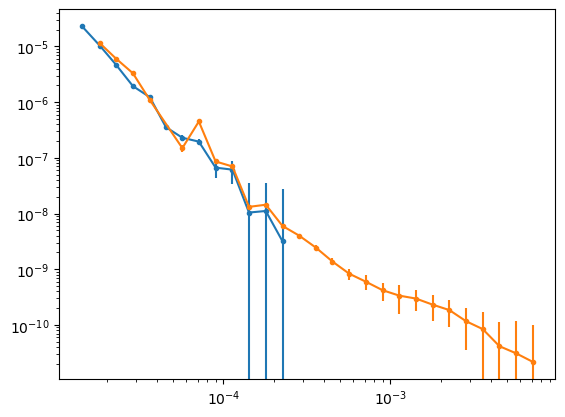

In [33]:
plt.errorbar(times_ch1, voltages_ch1,  voltages_std_ch1, marker='.')
plt.errorbar(times_ch2, voltages_ch2,  voltages_std_ch2, marker='.')
plt.xscale('log')
plt.yscale('log')

In [34]:
sweeps_lm[ii]['data']

,TIME,VOLTAGE,QUALITY
0,0.000002,-6.187110e-08,0
1,0.000006,-1.744540e-08,0
2,0.000010,1.959060e-05,0
3,0.000014,2.263350e-05,1
4,0.000018,1.091330e-05,1
5,0.000023,4.894120e-06,1
6,0.000029,1.902870e-06,1
7,0.000036,1.199970e-06,1
8,0.000045,3.354640e-07,1
9,0.000057,2.205880e-07,1


In [35]:
dobs = -np.r_[voltages_ch1, voltages_ch2]

In [36]:
source_area = np.prod(np.array(array_info['LOOP_SIZE'].split(',')).astype(float))
radius = np.sqrt(source_area/np.pi)

In [37]:
times_ch1

array([1.4190e-05, 1.8190e-05, 2.2690e-05, 2.8690e-05, 3.6190e-05,
       4.5190e-05, 5.6690e-05, 7.1190e-05, 8.9690e-05, 1.1319e-04,
       1.4219e-04, 1.7919e-04, 2.2569e-04])

In [38]:
lp_power_lm

1.0

## Model the response

In [39]:
thickness = np.array([10])
rho = np.array([12, 50])

In [40]:
# Source properties
source_location = np.array([0., 0., 0.])  
source_orientation = "z"                      # "x", "y" or "z"
source_current = 1.                           # maximum on-time current

# Receiver properties
receiver_location = np.array([0., 0., 0.])
receiver_orientation = "z"                    # "x", "y" or "z"
# Receiver list
# Define receivers at each location.
receivers_lm_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch1, "z",
        bw_cutoff_frequency=bw_cutoff_frequency_lm,
        bw_power=bw_power_lm,
        lp_cutoff_frequency=lp_cutoff_frequency_lm,
        lp_power=lp_power_lm,        
    ),
]  # Make a list containing all receivers even if just one

receivers_hm_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch2, "z",
        bw_cutoff_frequency=bw_cutoff_frequency_hm,
        bw_power=bw_power_hm,
        lp_cutoff_frequency=lp_cutoff_frequency_hm,
        lp_power=lp_power_hm,        
    ),
]  # Make a list containing all receivers even if just one

waveform_lm = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_lm, currents=input_currents_lm
)
waveform_hm = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_hm, currents=input_currents_hm
)
# Must define the transmitter properties and associated receivers
source_list = [
    tdem.sources.CircularLoop(
        receivers_lm_list,
        location=source_location,
        waveform=waveform_lm,
        radius=radius
    ),
    tdem.sources.CircularLoop(
        receivers_hm_list,
        location=source_location,
        waveform=waveform_hm,
        radius=radius
    ),    
]
survey = tdem.Survey(source_list)
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=thickness, sigmaMap=maps.IdentityMap(nP=len(rho)),
)

In [41]:
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

In [42]:
dpred = simulation.dpred(1./rho)

In [44]:
from SimPEG.utils import plot_1d_layer_model

(1, 100)

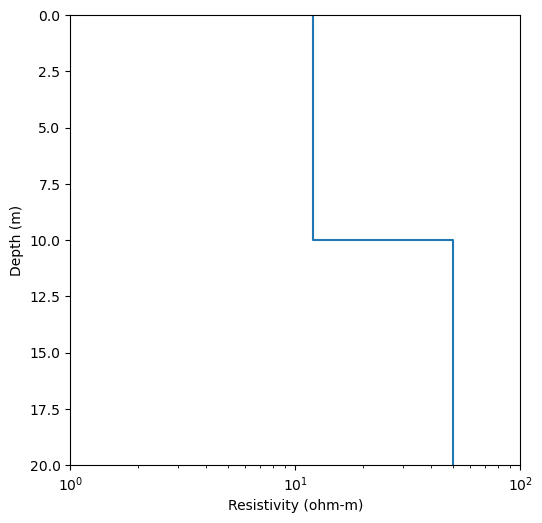

In [45]:
ax = plot_1d_layer_model(thickness, rho)
ax.set_xlabel("Resistivity (ohm-m)")
ax.set_xlim(1, 100)

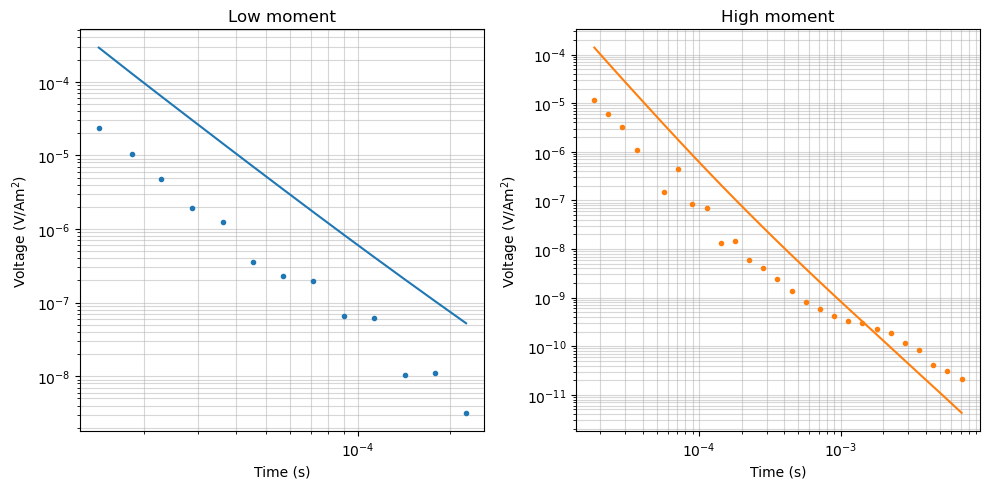

In [46]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
ax1.loglog(times_ch1, -dpred[:len(times_ch1)], color='C0')
ax1.loglog(times_ch1, -dobs[:len(times_ch1)], '.', color='C0')
ax2.loglog(times_ch2, -dpred[len(times_ch1):], color='C1')
ax2.loglog(times_ch2, -dobs[len(times_ch1):], '.', color='C1')
ax1.set_title("Low moment")
ax2.set_title("High moment")
for ax in axs:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V/Am$^2$)")
    ax.grid(True, which='both', alpha=0.5)
plt.tight_layout()

In [47]:
data_dict = {
    "voltages_ch1": voltages_ch1,
    "voltages_ch2": voltages_ch2,
    "voltages_std_ch1": voltages_std_ch1,
    "voltages_std_ch2": voltages_std_ch2,
    "source_list":source_list
}

In [48]:
import dill

dill.dump(data_dict, open("input_data.pik", "wb"))

In [49]:
survey